In [1]:
import tifffile
import numpy as np
from tqdm import tqdm
from pathlib import Path
import os
import pandas as pd
import sys
sys.path.append(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\10_code\UTvsXCT-preprocessing')
import dbtools as db
from preprocess_tools import io, sample_isolater

# Database conection

In [2]:
try:
    conn = db.connect()
    print("Connected to the database")
except Exception as error:
    print(error)

Connected to the database


# Data retrieval

We have to load the data from the database to get:

1. The file ids to use them as parent measurement

## Measurements file paths

In [3]:
original_paths = [Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\medidas\JI_4+5+7+8\volumen_eq')]

measurements_table = db.relation_metadata('measurements','samples','sample_measurements')

parent_id_column = 'measurementtype_id_measurement'

saving_folder = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas')

# for each original path, get the id_measurement where file_path_measurement is equal to the str of the original path

original_ids = []
original_measurementtype_ids = []
original_sample_names = []

for original_path in original_paths:
    original_path_str = str(original_path)
    original_id = measurements_table.loc[measurements_table['file_path_measurement'] == original_path_str, 'id_measurement'].values
    original_measurementtype_id = measurements_table.loc[measurements_table['file_path_measurement'] == original_path_str, parent_id_column].values[0]
    original_sample_name = measurements_table.loc[measurements_table['file_path_measurement'] == original_path_str, 'name_sample'].values
    original_ids.append(original_id)
    original_measurementtype_ids.append(original_measurementtype_id)
    original_sample_names.append(original_sample_name)
    print(f"Original path: {original_path_str}, ID: {original_id}", 
          f"Measurement type ID: {original_measurementtype_id}",
          f"Sample names: {original_sample_name}")

Original path: \\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\medidas\JI_4+5+7+8\volumen_eq, ID: [22 22 22 22] Measurement type ID: 2 Sample names: ['JI_4' 'JI_5' 'JI_7' 'JI_8']


## Functions

## Database loading

In [4]:
def load_measurement(file,file_path,parent_id,measurementtype_id,sample_names):

    parent_id_column = 'measurementtype_id'

    main_parameters = {'file_path':file_path,parent_id_column:measurementtype_id,'parent_measurement_id':parent_id}

    # metadata

    #for each parameter of the measurement a metadata has to be created

    metadata_parameters = []

    #dimensions
    metadata_parameters.append({'key':'height', 'value':str(file.shape[0]), 'type':'cardinal'})

    metadata_parameters.append({'key':'width', 'value':str(file.shape[1]), 'type':'cardinal'})

    metadata_parameters.append({'key':'depth', 'value':str(file.shape[2]), 'type':'cardinal'})

    #dtype

    metadata_parameters.append({'key':'dtype', 'value':str(file.dtype), 'type':'nominal'})

    #############################################################################################

    #MANUAL PARAMETERS

    #file type

    metadata_parameters.append({'key':'file_type', 'value':'folder', 'type':'nominal'})

    #aligned

    metadata_parameters.append({'key':'aligned', 'value':'False', 'type':'boolean'})

    #equalized

    metadata_parameters.append({'key':'equalized', 'value':'True', 'type':'boolean'})

    #axes
    metadata_parameters.append({'key':'axes', 'value':'x,y,z', 'type':'nominal'})

    print('Parameters to be inserted: ')
    for key, value in main_parameters.items():
        print(f"-    {key}: {value}")

    table_name = 'measurements'

    # Extract column names and values from the attributes dictionary
    columns = ', '.join(main_parameters.keys())
    values = ', '.join([f"'{v}'" for v in main_parameters.values()])

    # Construct the SQL INSERT statement
    sql = f"INSERT INTO {table_name} ({columns}) VALUES ({values})"

    print(sql)

    # Create a cursor object using the cursor() method
    cursor = conn.cursor()

    # Execute the SQL statement
    cursor.execute(sql)

    cursor.execute('COMMIT')

    cursor.close()

    data = db.get_data(table_name)

    data[data['file_path_measurement'] == str(file_path)]

    row_id = data['id_measurement'].values[-1]

    metadata_table_name =  table_name[:-1] + '_metadata'

    for attributes in metadata_parameters:

        attributes[table_name[:-1] + '_id'] = row_id

        # Extract column names and values from the attributes dictionary
        columns = ', '.join(attributes.keys())
        values = ', '.join([f"'{v}'" for v in attributes.values()])

        # Construct the SQL INSERT statement
        sql = f"INSERT INTO {metadata_table_name} ({columns}) VALUES ({values})"

        print(sql)

        # Create a cursor object using the cursor() method
        cursor = conn.cursor()

        # Execute the SQL statement
        cursor.execute(sql)

        cursor.execute('COMMIT')

        cursor.close()
    
    samples_data = db.get_data_metadata('samples')

    #get the ids of the samples in sample_names
    samples_data = samples_data[samples_data['name_sample'].isin(sample_names)]

    sample_ids = samples_data['id_sample'].values.tolist()

    relational_table_name = 'sample_measurements'

    for sample_id in sample_ids:

        relational_parameters = {'sample_id': sample_id, 'measurement_id': row_id}

        # Extract column names and values from the attributes dictionary
        columns = ', '.join(relational_parameters.keys())
        values = ', '.join([f"'{v}'" for v in relational_parameters.values()])

        # Construct the SQL INSERT statement
        sql = f"INSERT INTO {relational_table_name} ({columns}) VALUES ({values})"

        print(sql)

        # Create a cursor object using the cursor() method
        cursor = conn.cursor()

        # Execute the SQL statement
        cursor.execute(sql)

        cursor.execute('COMMIT')

        cursor.close()

## main loop

For each file:

1. Load it

2. Separate the samples in it

3. Save each isolated sample

4. Save them to the database

In [5]:
for i in range(len(original_paths)):
    # Get the original path and ID
    original_path = original_paths[i]
    original_id = original_ids[i]
    original_measurementtype_id = original_measurementtype_ids[i]
    original_sample_name = original_sample_names[i]
    number_of_samples = len(original_sample_name)

    #load the volume
    volume = io.load_tif(original_path)

    #isolate the samples
    isolated_volumes = sample_isolater.isolate_samples(volume, number_of_samples)

    for j,isolated_volume in enumerate(isolated_volumes):

        folder_name = saving_folder / original_sample_name[j]

        print(f"Saving isolated volume for sample {original_sample_name[j]} in folder {folder_name}")
        
        # #save the volume
        # #save it in the parent folder of it with the name aligned_90rotleft_reslicebottom.tif
        # save_path = original_path.parent / f"aligned_90rotright_reslicetop.tif"
        # #save in the path
        # io.save_tif(save_path, volume)

        # #update the database
        # load_measurement(volume,save_path,original_id,original_measurementtype_id,original_sample_name)

Progress: 100%|██████████| 3224/3224 [01:25<00:00, 37.53it/s]


Saving isolated volume for sample JI_4 in folder \\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\JI_4
Saving isolated volume for sample JI_5 in folder \\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\JI_5
Saving isolated volume for sample JI_7 in folder \\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\JI_7
Saving isolated volume for sample JI_8 in folder \\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\JI_8


In [6]:
a = isolated_volumes[0]

print(a.shape)

print(a.min())

(3224, 1610, 240)
0


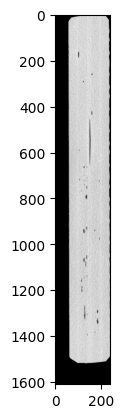

In [7]:
import matplotlib.pyplot as plt

plt.imshow(a[-1,:,:], cmap='gray')

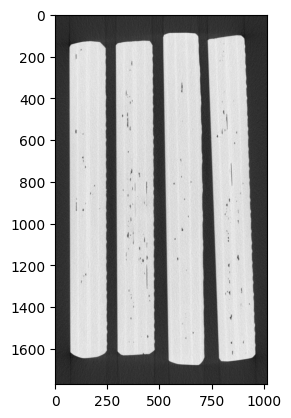

In [8]:
plt.imshow(volume[volume.shape[0] // 2], cmap='gray')

In [9]:
volume[volume.shape[0] // 2, volume.shape[1] // 2].min()

np.uint8(38)